### Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed
import matplotlib.pyplot as plt

### Loading the Dataset

In [2]:
df = pd.read_csv('preprocessed_data.csv')

### Tokenization

In [3]:
eng_tokenizer = Tokenizer()
ger_tokenizer = Tokenizer()

eng_tokenizer.fit_on_texts(df['English'])
ger_tokenizer.fit_on_texts(df['German'])

eng_sequences = eng_tokenizer.texts_to_sequences(df['English'])
ger_sequences = ger_tokenizer.texts_to_sequences(df['German'])

### Padding

In [4]:
# Determining a fixed maximum length for both sequences
max_eng_len = max(len(seq) for seq in eng_sequences)
max_ger_len = max(len(seq) for seq in ger_sequences)
max_len = max(max_eng_len, max_ger_len)  


# Padding both English and German sequences to the same length
eng_padded = pad_sequences(eng_sequences, maxlen=max_len, padding='post')
ger_padded = pad_sequences(ger_sequences, maxlen=max_len, padding='post')

### Defining and Training the Model

In [6]:
model = Sequential([
    Embedding(input_dim=len(eng_tokenizer.word_index) + 1, output_dim=128),
    SimpleRNN(128, return_sequences=True),
    TimeDistributed(Dense(len(ger_tokenizer.word_index) + 1, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Expanding the target dimensions: ger_padded shape becomes (num_samples, max_len, 1)
ger_targets = np.expand_dims(ger_padded, -1)

history = model.fit(eng_padded, ger_targets, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 314s 125ms/step - accuracy: 0.7863 - loss: 1.9346 - val_accuracy: 0.7819 - val_loss: 1.5286
Epoch 2/3
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 313s 125ms/step - accuracy: 0.8412 - loss: 1.0251 - val_accuracy: 0.7938 - val_loss: 1.3791
Epoch 3/3
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 311s 124ms/step - accuracy: 0.8542 - loss: 0.8493 - val_accuracy: 0.7997 - val_loss: 1.3131


### Training Visualization

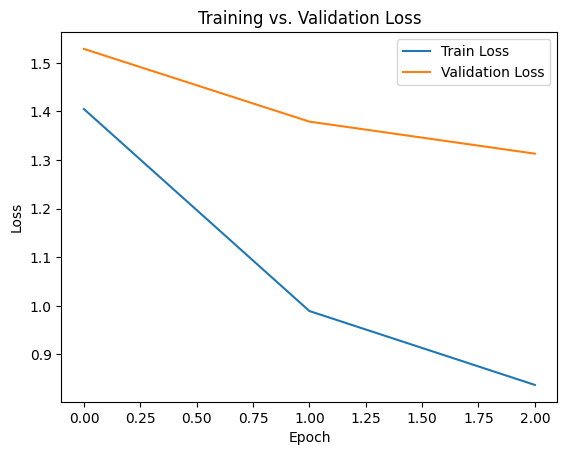

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Validation

In [8]:
# Validate on 30 samples
print("\n--- Validation on 30 samples ---\n")
for i in range(30):
    eng_sentence = df['English'][i]
    actual_translation = df['German'][i]
    input_seq = pad_sequences(eng_tokenizer.texts_to_sequences([eng_sentence]), maxlen=max_len, padding='post')
    
    # Get model predictions; prediction shape: (1, max_len, vocab_size)
    prediction = np.argmax(model.predict(input_seq), axis=-1)
    
    # Convert predicted indices to words; ignore padding zeros
    predicted_sentence = ' '.join([ger_tokenizer.index_word.get(idx, '<UNK>') 
                                   for idx in prediction[0] if idx != 0])
    print(f"English: {eng_sentence}")
    print(f"Actual German: {actual_translation}")
    print(f"Predicted German: {predicted_sentence}\n")


--- Validation on 30 samples ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
English: go
Actual German: geh
Predicted German: geh

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
English: hi
Actual German: hallo
Predicted German: hallo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
English: hi
Actual German: grüß gott
Predicted German: hallo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
English: run
Actual German: lauf
Predicted German: sprich

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
English: run
Actual German: lauf
Predicted German: sprich

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
English: wow
Actual German: potzdonner
Predicted German: mein

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
English: wow
Actual German: donnerwetter
Predicted German: mein

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
English: duck
Actual German: kopf runter
Predicted German: sie

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
English: fire
Actual German: feuer
Predicted German: tom

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
English: help
Actual German: hilfe
Predict

### Testing

In [11]:
while True:
    user_input = input("Enter English text (or 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    input_seq = pad_sequences(eng_tokenizer.texts_to_sequences([user_input]), maxlen=max_len, padding='post')
    prediction = np.argmax(model.predict(input_seq), axis=-1)
    predicted_sentence = ' '.join([ger_tokenizer.index_word.get(idx, '<UNK>') 
                                   for idx in prediction[0] if idx != 0])
    print(f"Predicted German translation: {predicted_sentence}\n")

Enter English text (or 'exit' to quit):  can i help


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted German translation: können ich mir



Enter English text (or 'exit' to quit):  tell me something


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted German translation: sag mir etwas



Enter English text (or 'exit' to quit):  lets be friends


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted German translation: lasst wir freunde



Enter English text (or 'exit' to quit):  i am tired


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted German translation: ich bin müde



Enter English text (or 'exit' to quit):  give me tea


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted German translation: gib mir tee



Enter English text (or 'exit' to quit):  lets go home


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted German translation: lasst wir nach hause



Enter English text (or 'exit' to quit):  whats for breakfast


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted German translation: was für es



Enter English text (or 'exit' to quit):  exit
